In [1]:
# ==============================
# 1. IMPORTS
# ==============================
import os
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision


# Check device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Using device: cpu


In [2]:
# ==============================
# 2. CONFIG
# ==============================
DATA_ROOT = r"D:/viot/Data_Split/train"
VAL_ROOT = r"D:/viot/Data_Split/val"
BATCH_SIZE = 32
NUM_EPOCHS = 20
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)


In [3]:
# ==============================
# 3. DATA TRANSFORMS
# ==============================
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [4]:
# ==============================
# 4. DATASET & DATALOADER
# ==============================
train_dataset = datasets.ImageFolder(root=DATA_ROOT, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=VAL_ROOT, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Quick preview of classes
print("Classes:", train_dataset.classes)
print("Number of training images:", len(train_dataset))
print("Number of validation images:", len(val_dataset))


Classes: ['Dry', 'Healthy', 'Unhealthy']
Number of training images: 77894
Number of validation images: 12847


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


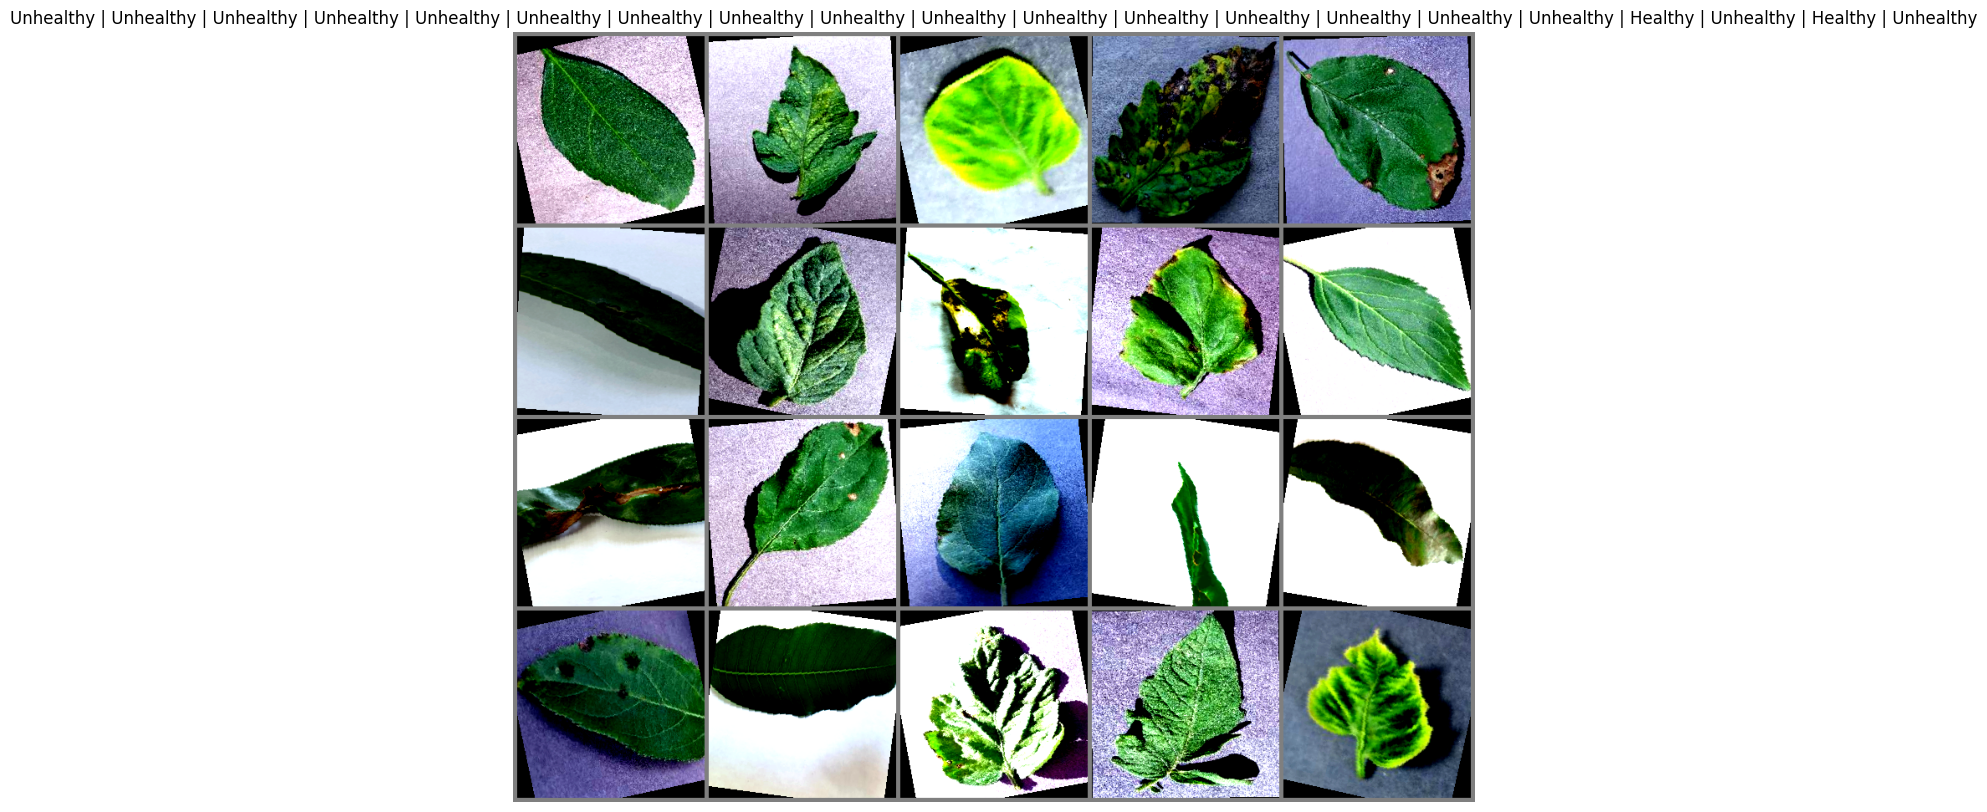

In [6]:
# ==============================
# 5. HELPER FUNCTIONS
# ==============================
import torchvision

def imshow(img, title=None):
    """Display a tensor image with optional title"""
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    if title:
        plt.title(title, fontsize=12)
    plt.axis('off')
    plt.show()

# -----------------------------
# Show 20 training images
# -----------------------------
dataiter = iter(train_loader)
images, labels = next(dataiter)  # first batch

# If batch has fewer than 20, show all
num_to_show = min(20, images.size(0))
images_grid = torchvision.utils.make_grid(images[:num_to_show], nrow=5, padding=5)
titles = [train_dataset.classes[x] for x in labels[:num_to_show]]

# Join titles into a single string
title_str = " | ".join(titles)

imshow(images_grid, title=title_str)


In [7]:
# ==============================
# 6. STAGE 0: LEAF DETECTION MODEL
# ==============================
# Binary classification: Leaf / Non-Leaf
model_stage0 = models.efficientnet_b0(pretrained=True)
num_features = model_stage0.classifier[1].in_features
model_stage0.classifier[1] = nn.Linear(num_features, 1)  # Binary output
model_stage0 = model_stage0.to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_stage0.parameters(), lr=1e-4)


d:\Programs\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Programs\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# ==============================
# 7. TRAIN FUNCTION
# ==============================
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=NUM_EPOCHS, stage_name="Stage"):
    best_acc = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE).float()
            optimizer.zero_grad()
            outputs = model(imgs).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE).float()
                outputs = model(imgs).squeeze(1)
                preds = torch.sigmoid(outputs) > 0.5
                correct += (preds == labels.byte()).sum().item()
                total += labels.size(0)
        acc = correct / total
        print(f"[{stage_name}] Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader.dataset):.4f} | Val Acc: {acc:.4f}")
        
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), f"best_{stage_name}.pth")
    print(f"[{stage_name}] Training finished! Best Val Acc: {best_acc:.4f}")


In [11]:
# ==============================
# 8. TRAIN STAGE 0
# ==============================
train_model(model_stage0, criterion, optimizer, train_loader, val_loader, NUM_EPOCHS, stage_name="Stage0_LeafDetection")


KeyboardInterrupt: 

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm

# ==============================
# 1. CONFIG
# ==============================
DATA_ROOT = r"D:\viot\leaf_detector_dataset"
BATCH_SIZE = 16
NUM_EPOCHS = 5       # Enough for small dataset
NUM_CLASSES = 2      # Leaf / Not Leaf
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==============================
# 2. DATA
# ==============================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(DATA_ROOT, "train"), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(DATA_ROOT, "val"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ==============================
# 3. MODEL
# ==============================
model = models.mobilenet_v3_small(pretrained=True)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ==============================
# 4. TRAIN
# ==============================
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Train Loss: {total_loss/len(train_loader):.4f}")

    # Validate
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f"Val Accuracy: {acc*100:.2f}%")

# ==============================
# 5. SAVE MODEL
# ==============================
torch.save(model.state_dict(), "leaf_detector.pth")
print(" Leaf vs Not Leaf detector model saved!")


d:\Programs\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Programs\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\User/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:01<00:00, 8.99MB/s]
Epoch 1/5:   3%|▎         | 1/33 [00:02<01:24,  2.63s/it]


UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='D:\\viot\\leaf_detector_dataset\\train\\not_leaf\\dog_65.jpg'>